In [8]:
from utils.SaxImage import SAXImage
import SimpleITK as sitk
import os
import numpy as np
import cv2
from skimage import transform
from torchvision import transforms
import torch

subject = "../Dataset/Subjects/1003814/image/time001"
gt_path = "../Dataset/Masks/1003814/time001"
segpath = "../Predictions/Surface/ROI_WDS_1_WL_0.01_3D_32_2D_8_KL_1e-5/Masks/1003814/time001"

SAX_PATH = os.path.join(subject, "SAX")

SaxImage = SAXImage(SAX_PATH)
SaxImage_array = SaxImage.pixel_array()
SaxImage_array = (SaxImage_array - np.min(SaxImage_array)) / (np.max(SaxImage_array) - np.min(SaxImage_array))

Segmentation = sitk.ReadImage(os.path.join(segpath, "mask.nii.gz"))
Segmentation_array = sitk.GetArrayFromImage(Segmentation)
Segmentation_array = np.transpose(Segmentation_array, (1, 2, 0))

GroundTruth = sitk.ReadImage(os.path.join(gt_path, "mask.nii.gz"))
GroundTruth_array = sitk.GetArrayFromImage(GroundTruth)
GroundTruth_array = np.transpose(GroundTruth_array, (1, 2, 0))

labels = [50, 100, 150, 200, 250]
colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0), (255, 0, 255)]

# generate a plot for 3 intermediate slices using matplotlib
# slices are the last axis in the arrays


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011516315..76.971596].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011516315..76.971596].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007677543..76.90307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007677543..76.90307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007677543..76.88426].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007677543..76.8668].


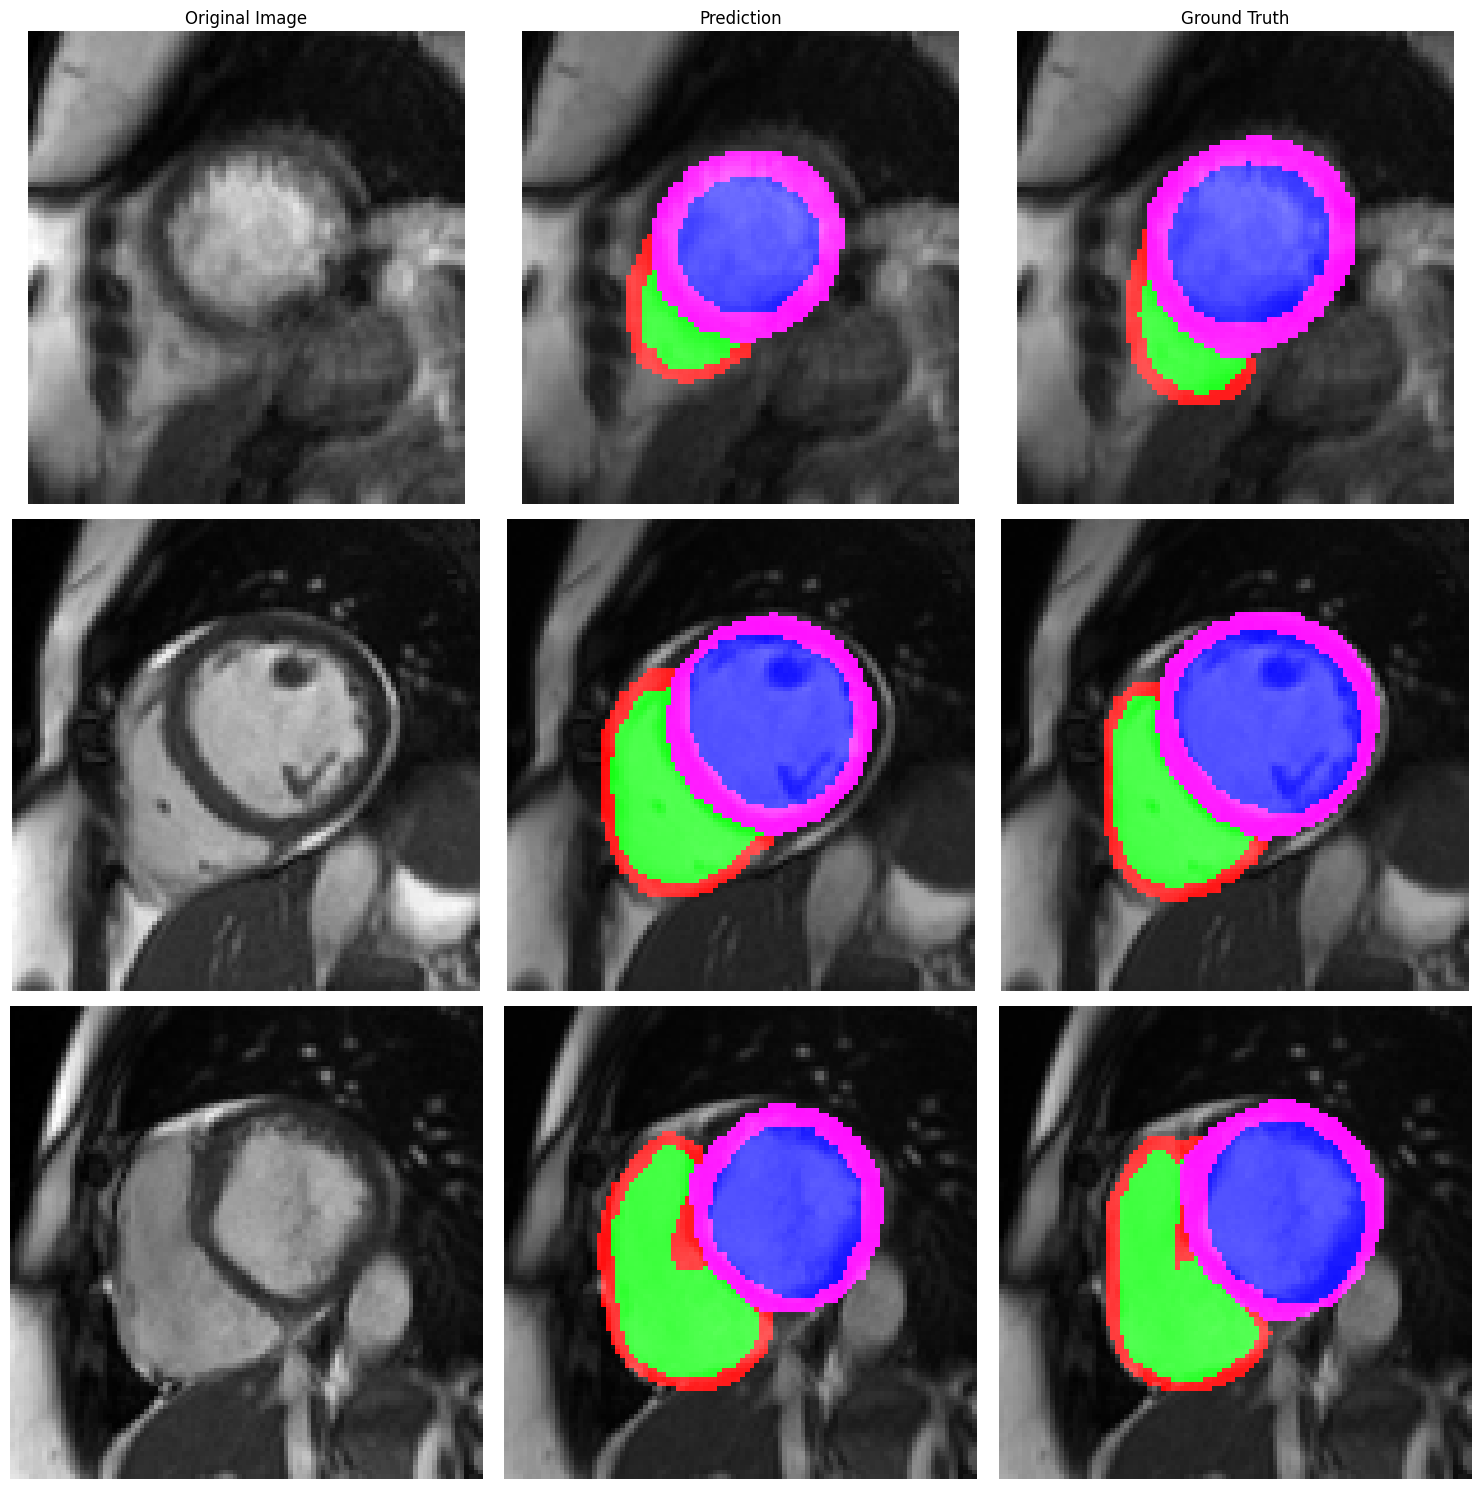

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_roi_bounds(mask_array):
    """Get the ROI boundaries where segmentation exists"""
    # Find indices where any label exists
    indices = np.where(mask_array > 0)
    
    if len(indices[0]) == 0:  # If no segmentation found
        return None
    
    # Get min and max coordinates with some padding
    padding = 20
    y_min = max(0, np.min(indices[0]) - padding)
    y_max = min(mask_array.shape[0], np.max(indices[0]) + padding)
    x_min = max(0, np.min(indices[1]) - padding)
    x_max = min(mask_array.shape[1], np.max(indices[1]) + padding)
    
    return y_min, y_max, x_min, x_max

def create_overlay(image, mask, colors, labels):
    """Create an RGB overlay of the mask on the image"""
    overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    for label, color in zip(labels, colors):
        mask_binary = (mask == label).astype(np.uint8)
        for c in range(3):
            overlay[:, :, c] = np.where(mask_binary == 1,
                                      overlay[:, :, c] * 0.7 + color[c] * 0.3,
                                      overlay[:, :, c])
    return overlay

# Get total number of slices and select 3 evenly spaced indices
num_slices = SaxImage_array.shape[2]
slice_indices = [num_slices//4, num_slices//2, 3*num_slices//4]

# Create figure with 3 rows (one for each slice) and 3 columns (original, prediction, ground truth)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for row, slice_idx in enumerate(slice_indices):
    # Get ROI bounds from either prediction or ground truth
    combined_mask = np.logical_or(Segmentation_array[:, :, slice_idx] > 0, 
                                GroundTruth_array[:, :, slice_idx] > 0)
    bounds = get_roi_bounds(combined_mask)
    
    if bounds is None:
        continue
        
    y_min, y_max, x_min, x_max = bounds
    
    # Original image
    axes[row, 0].imshow(SaxImage_array[y_min:y_max, x_min:x_max, slice_idx], cmap='gray')
    if row == 0:
        axes[row, 0].set_title(f'Original Image')
    axes[row, 0].axis('off')
    
    # Prediction overlay
    pred_overlay = create_overlay(SaxImage_array[y_min:y_max, x_min:x_max, slice_idx].copy(),
                                Segmentation_array[y_min:y_max, x_min:x_max, slice_idx],
                                colors, labels)
    axes[row, 1].imshow(pred_overlay)
    if row == 0:
        axes[row, 1].set_title(f'Prediction')
    axes[row, 1].axis('off')
    
    # Ground truth overlay
    gt_overlay = create_overlay(SaxImage_array[y_min:y_max, x_min:x_max, slice_idx].copy(),
                              GroundTruth_array[y_min:y_max, x_min:x_max, slice_idx],
                              colors, labels)
    axes[row, 2].imshow(gt_overlay)
    if row == 0:    
        axes[row, 2].set_title(f'Ground Truth')
    axes[row, 2].axis('off')

plt.tight_layout()
plt.show()

# Optional: Save the figure
# plt.savefig('cardiac_mri_segmentation_roi.png', bbox_inches='tight', dpi=300)